In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
del train['id']

train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


In [4]:
predictors = train.columns[:-1].to_list()
train = train.groupby(predictors).agg('mean').reset_index()

<AxesSubplot:>

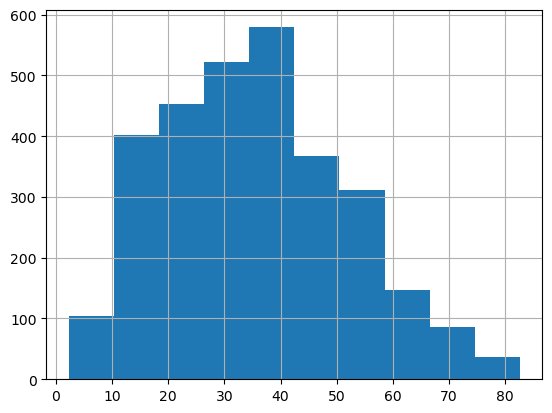

In [5]:
train['Strength'].hist()

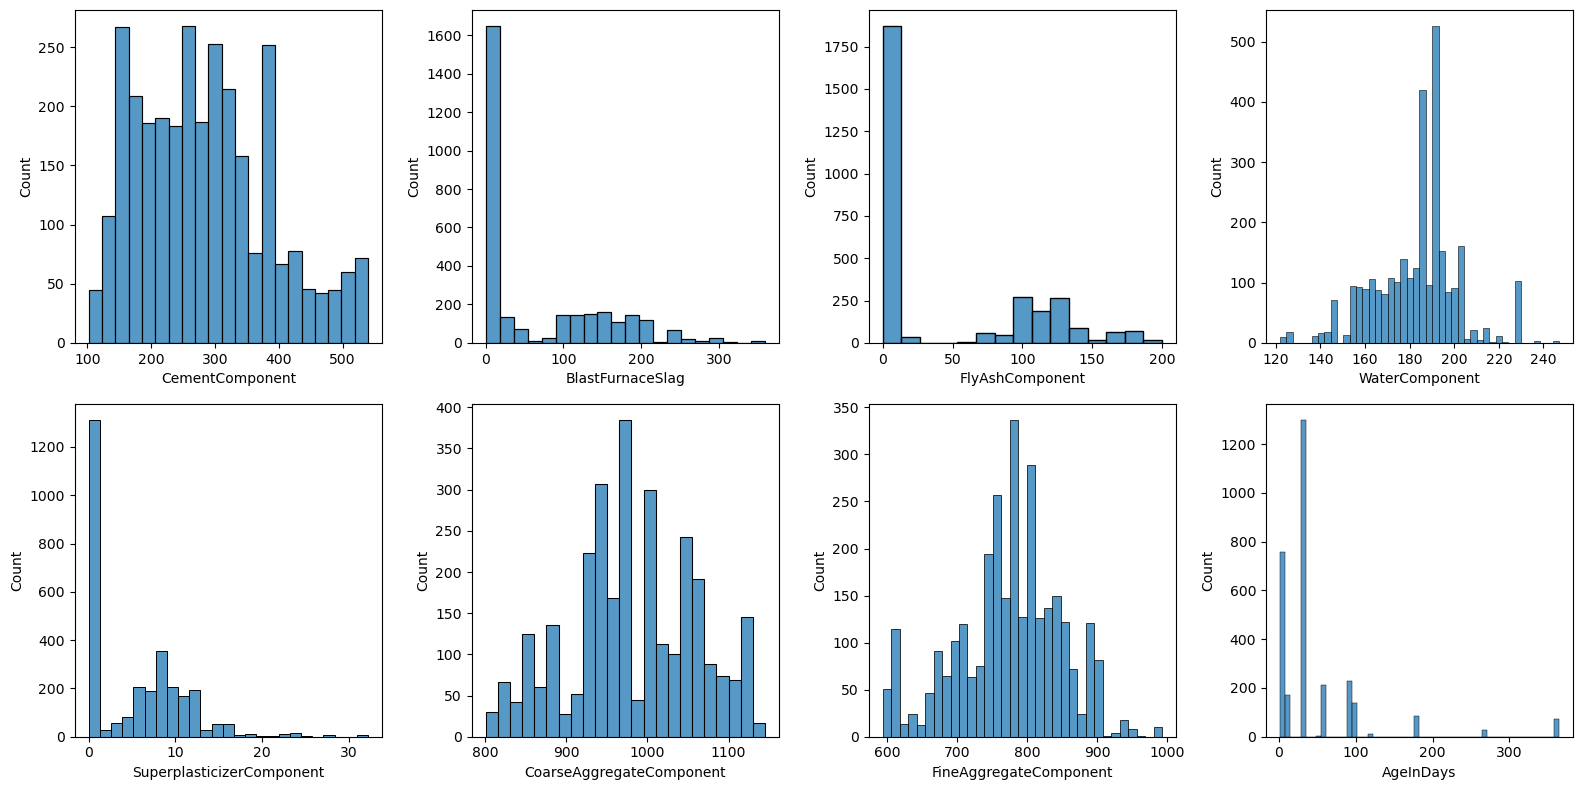

In [6]:
# histograms of predictors
n_rows = 2
n_cols = 4

fig,axs = plt.subplots(n_rows,n_cols,figsize=(4*n_cols,4*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols*i+j
        _ = sns.histplot(data=train,x=train.columns[col_idx],ax=axs[i][j])
        
fig.tight_layout()

Some of the predictors have a rather larger number of zero values. 

In [7]:
zero_value_cols = ['BlastFurnaceSlag','FlyAshComponent','SuperplasticizerComponent']
for col in zero_value_cols:
    print('Proportion of zero_values observations for col %s: %5.3f' %(col,(train[col]==0).mean()))

Proportion of zero_values observations for col BlastFurnaceSlag: 0.537
Proportion of zero_values observations for col FlyAshComponent: 0.623
Proportion of zero_values observations for col SuperplasticizerComponent: 0.437


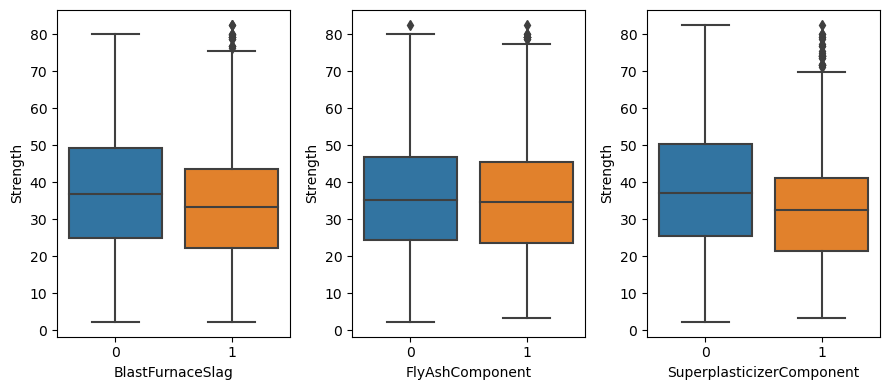

In [8]:
fig,axs = plt.subplots(1,len(zero_value_cols),figsize=(3*len(zero_value_cols),4))
for i,col in enumerate(zero_value_cols):
    indicator = 1*(train[col] == 0)
    _ = sns.boxplot(y=train['Strength'],x=indicator,ax=axs[i])

fig.tight_layout()

In [9]:
from sklearn.preprocessing import StandardScaler


input_sc = StandardScaler()
output_sc = StandardScaler()

X = input_sc.fit_transform(train.drop('Strength',axis=1).values)
y = output_sc.fit_transform(train[['Strength']].values).ravel()
original_std = output_sc.scale_

## 2-layer multi-layer perceptron

In [10]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

from typing import Dict, Optional

In [11]:
def construct_model(params:Dict) -> keras.Model:
    """
    Build 2-layer MLP for hyperparameters tuning

    hp: HyperParameters class instance
    """
    n_hidden = 2 # TODO: use this as a hyperparameter
    n_hidden_list = [params['hsize%d'%i] for i in range(1,n_hidden+1)]
    dropouts_list = [params['dropout%d'%i] for i in range(1,n_hidden+1)]

    model = keras.Sequential()
    model.add(keras.layers.Dense(n_hidden_list[0],input_shape=(X.shape[-1],),activation='selu',kernel_initializer='lecun_normal'))
    model.add(keras.layers.AlphaDropout(dropouts_list[0]))

    if n_hidden > 1:
        for i in range(1,n_hidden):
            model.add(keras.layers.Dense(n_hidden_list[i],activation='selu',kernel_initializer='lecun_normal'))
            model.add(keras.layers.AlphaDropout(dropouts_list[i]))
            
    # output is between 0 and 1
    model.add(keras.layers.Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mean_squared_error'
    )

    return model


def build_and_fit(
    params:Dict,X:np.ndarray,y:np.ndarray,
    verbose:bool=False,
    resample_seed:Optional[int]=None
) -> keras.Model:
    #further divide into train and validation splits for early stopping
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.1,random_state=resample_seed)
    
    EPOCHS = 100
    BATCH_SIZE = params['batch_size']
        
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=0,
        patience=10,
        restore_best_weights=True
    )
        
        
    # create model
    model = construct_model(params)

    # train model
    _ = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        verbose=verbose,
    )

    return model

### Hyperparameter tuning

We will use the hyperopt library to tune the hyperparameters

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll_utils import scope

In [13]:
# generate train_test_splits
splits = list(KFold(n_splits=8,shuffle=True,random_state=1).split(X,y))
len(splits)

8

In [14]:
def fit_and_test_fold(params:Dict,train_index:np.ndarray,test_index:np.ndarray) -> float:
    X_train = X[train_index,...]; X_test = X[test_index,...]
    y_train = y[train_index]; y_test = y[test_index]
    
    
    model = build_and_fit(params,X_train,y_train)

    # obtain test predictions
    test_preds = model.predict(X_test,verbose=False).ravel()
    
    # return RMSE
    return np.sqrt(mean_squared_error(y_test,test_preds))*original_std

def objective(params:Dict) -> Dict:
    tf.keras.backend.clear_session()
#     cv_losses = [None]*len(splits)
#     for i,(train_index,test_index) in enumerate(splits):
#         cv_losses[i] = fit_and_test_fold(params,train_index,test_index)
    
    # NOT using GPU in this notebook
    cv_losses = Parallel(n_jobs=4,verbose=0)(
        delayed(fit_and_test_fold)(params,train_index,test_index) for train_index,test_index in splits
    )
    
    return {'loss':np.mean(cv_losses),'status': STATUS_OK,'min_RMSE_fold':np.min(cv_losses),'max_RMSE_fold':np.max(cv_losses)}

search_space = {
    'hsize1': scope.int(hp.quniform('hsize1',2,150,1)),
    'hsize2': scope.int(hp.quniform('hsize2',2,150,1)),
    'dropout1': hp.uniform('dropout1',0.01,0.5),
    'dropout2': hp.uniform('dropout2',0.01,0.5),
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.1)),
    'batch_size':scope.int(hp.quniform('batch_size',32,1024,1)),
}

trials = Trials()
best = fmin(
    objective,search_space,
    algo=tpe.suggest,
    max_evals = 100,
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

 64%|██████▍   | 64/100 [14:06<05:40,  9.45s/trial, best loss: 12.079809119124455]

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



100%|██████████| 100/100 [22:07<00:00, 13.27s/trial, best loss: 12.037573064462928]


{'batch_size': 430,
 'dropout1': 0.010450274259104476,
 'dropout2': 0.03438848058867812,
 'hsize1': 46,
 'hsize2': 128,
 'learning_rate': 0.0077311904033691295}

In [15]:
results = pd.DataFrame(trials.vals)
results['RMSE'] = [tmp['loss'] for tmp in trials.results]
results['min_RMSE_fold'] = [tmp['min_RMSE_fold'] for tmp in trials.results]
results['max_RMSE_fold'] = [tmp['max_RMSE_fold'] for tmp in trials.results]
results.to_csv('cv_rmse_hyperopt.csv',index=False)
# top 10 configurations
results.sort_values('RMSE',ascending=True).head(10)

,batch_size,dropout1,dropout2,hsize1,hsize2,learning_rate,RMSE,min_RMSE_fold,max_RMSE_fold
67,430.0,0.010450,0.034388,46.0,128.0,0.007731,12.037573,11.285827,12.800012
68,537.0,0.022843,0.034701,54.0,130.0,0.006784,12.046509,11.352854,12.796913
65,494.0,0.022972,0.040263,20.0,118.0,0.016112,12.048721,11.445551,12.823399
66,483.0,0.019805,0.039815,45.0,128.0,0.017562,12.054181,11.451809,12.757066
86,422.0,0.019448,0.024650,34.0,113.0,0.005445,12.054932,11.321574,12.865140
71,431.0,0.040221,0.085420,69.0,124.0,0.003436,12.059578,11.287325,12.849941
73,605.0,0.058600,0.057884,23.0,140.0,0.032501,12.065927,11.346157,13.221272
57,409.0,0.011010,0.014629,42.0,109.0,0.010106,12.079809,11.445714,12.827628
78,367.0,0.067836,0.033089,45.0,103.0,0.020363,12.093362,11.353747,12.952374
79,561.0,0.030116,0.054389,56.0,113.0,0.004165,12.131860,11.564171,12.851304


## Final model

Rather than training a single model, we will train an ensemble of models, where each model is trained using a different training-validation split

In [16]:
keras.backend.clear_session()
n_ensemble = 10
models = [None]*n_ensemble

for i in range(n_ensemble):
    print(f'********* Model {i+1} *********')
    models[i] = build_and_fit(best,X,y,verbose=True,resample_seed=i)
    print()

********* Model 1 *********
Epoch 1/100
7/7 [==============================] - 1s 43ms/step - loss: 1.6436 - val_loss: 1.1069
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 1.1401 - val_loss: 0.8464
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.8935 - val_loss: 0.7811
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.8425 - val_loss: 0.7297
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.7716 - val_loss: 0.7476
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 0.7414 - val_loss: 0.6818
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.7276 - val_loss: 0.6958
Epoch 8/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7091 - val_loss: 0.6946
Epoch 9/100
7/7 [==============================] - 0s 11ms/step - loss: 0.6853 - val_loss: 0.6691
Epoch 10/100
7/7 [==============================] - 0s 10ms/step - loss: 0.6744 - val_loss

In [17]:
# Create ensemble model in Keras
model_input = tf.keras.Input(shape=(X.shape[1],))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

print(ensemble_model.summary())

ensemble_model.save('ensemble_model.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1)            6559        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 1)            6559        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 1)            6559        ['input_1[0][0]']                
                                                                                              

## Generate test predictions

In [18]:
X_test = input_sc.transform(test.drop('id',axis=1).values)
y_test_pred = ensemble_model.predict(X_test)

y_test_pred_orig = output_sc.inverse_transform(y_test_pred.reshape(-1,1)).ravel()

submission = pd.DataFrame({'id':test['id'].values,'Strength':y_test_pred_orig})
submission.to_csv('submission.csv',index=False)

113/113 [==============================] - 1s 2ms/step
